In [15]:
import torch 

test = torch.randint(0,10,(2,5,5))

In [16]:
test

tensor([[[0, 8, 3, 4, 3],
         [0, 2, 7, 7, 3],
         [8, 6, 6, 8, 6],
         [1, 1, 8, 3, 2],
         [6, 9, 0, 5, 8]],

        [[1, 0, 6, 8, 7],
         [1, 3, 6, 4, 6],
         [8, 4, 5, 7, 5],
         [7, 0, 9, 0, 8],
         [6, 1, 9, 3, 8]]])

In [17]:
arg_max_indexs =torch.argmax(test,dim=0)
arg_max_indexs


tensor([[1, 0, 1, 1, 1],
        [1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0]])

In [28]:

import numpy as np 

# test_np = test.numpy()
# arg_max_indexs = arg_max_indexs.numpy()
test_bool = torch.zeros_like(test).bool()

def linidx_take(val_arr, z_indices):

    # Get number of columns and rows in values array
    _, nC, nR = val_arr.shape

    # Get linear indices and thus extract elements with np.take
    idx = nC*nR*z_indices + nR*torch.arange(nR)[:,None] + torch.arange(nC)
    print(idx)
    return  val_arr.ravel()[idx], idx


vals,idx=linidx_take(test, arg_max_indexs)

#test_np.choose(arg_max_indexs)


tensor([[25,  1, 27, 28, 29],
        [30, 31,  7,  8, 34],
        [10, 11, 12, 13, 14],
        [40, 16, 42, 18, 44],
        [20, 21, 47, 23, 24]])


In [33]:

idx.ravel()


tensor([25,  1, 27, 28, 29, 30, 31,  7,  8, 34, 10, 11, 12, 13, 14, 40, 16, 42,
        18, 44, 20, 21, 47, 23, 24])

In [50]:
test_ravel_shape=test.ravel().shape
bool_array = torch.zeros(test_ravel_shape, dtype=bool)
bool_array[idx.ravel()] = True


In [51]:
bool_array


tensor([False,  True, False, False, False, False, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True, False, False,  True, False, False, False, False, False,
         True, False,  True, False,  True, False, False,  True, False, False])

In [52]:
test_bool=bool_array.reshape(test.shape)

In [53]:
test_bool


tensor([[[False,  True, False, False, False],
         [False, False,  True,  True, False],
         [ True,  True,  True,  True,  True],
         [False,  True, False,  True, False],
         [ True,  True, False,  True,  True]],

        [[ True, False,  True,  True,  True],
         [ True,  True, False, False,  True],
         [False, False, False, False, False],
         [ True, False,  True, False,  True],
         [False, False,  True, False, False]]])

In [54]:
test_bool.float()


tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 1., 0.],
         [1., 1., 1., 1., 1.],
         [0., 1., 0., 1., 0.],
         [1., 1., 0., 1., 1.]],

        [[1., 0., 1., 1., 1.],
         [1., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1.],
         [0., 0., 1., 0., 0.]]])

In [55]:
test*test_bool.float()


tensor([[[0., 8., 0., 0., 0.],
         [0., 0., 7., 7., 0.],
         [8., 6., 6., 8., 6.],
         [0., 1., 0., 3., 0.],
         [6., 9., 0., 5., 8.]],

        [[1., 0., 6., 8., 7.],
         [1., 3., 0., 0., 6.],
         [0., 0., 0., 0., 0.],
         [7., 0., 9., 0., 8.],
         [0., 0., 9., 0., 0.]]])

In [46]:
test[0],test[1]

(tensor([[0, 8, 3, 4, 3],
         [0, 2, 7, 7, 3],
         [8, 6, 6, 8, 6],
         [1, 1, 8, 3, 2],
         [6, 9, 0, 5, 8]]),
 tensor([[1, 0, 6, 8, 7],
         [1, 3, 6, 4, 6],
         [8, 4, 5, 7, 5],
         [7, 0, 9, 0, 8],
         [6, 1, 9, 3, 8]]))

In [26]:
torch.index_select(test_bool, 0, idx)


IndexError: index_select(): Index is supposed to be a vector

In [9]:
test[arg_max_indexs].shape,arg_max_indexs.shape

(torch.Size([1, 5, 5, 5, 5]), torch.Size([1, 5, 5]))

# Vis Inference Predicitons 

In [ ]:
import torch


classes = torch.rand((1, 300, 101),)
test_vis_gt = torch.randint(low=0, high=1, size=(1, 15, 300, 50, 50))
test_vis = torch.rand((1,100,300,50,50))

 maybe class predictions * the sum assignment over waiting and then do the predictions 

```python 
cost_class = b_out_prob[:, b_tgt_ids]
 C = self.cost_dice * cost_dice + self.cost_class * cost_class
          C = C.cpu()
assignment = linear_sum_assignment(C, maximize=True)
indices.append(assignment)

# loop to select classes and predictions 
```
and th

# Vis Logs

In [1]:
import numpy as np 


import json
import os 

log_path = os.path.join(
    r"/home/niklas/ETM_BEV/BEVerse/logs_cluster/20221212_111515.log.json")


epoch = []
steps = []
loss_overall = []
loss_ce = []
loss_mask = []
loss_dice = []
lr = []
cardinality_error = []
class_error = []


with open(log_path, mode="r") as log_file:
    for i,l in enumerate(log_file.readlines()):
        if i == 0:
            continue
        cur_dict =json.loads(l)
        steps.append(i-1)
        epoch.append(cur_dict["epoch"])
        loss_overall.append(cur_dict["loss"])
        loss_ce.append(cur_dict["loss_ce"])
        loss_mask.append(cur_dict["loss_mask"])
        loss_dice.append(cur_dict["loss_dice"])
        lr.append(cur_dict["lr"])
        cardinality_error.append(cur_dict["cardinality_error"])
        class_error.append(cur_dict["class_error"])

In [2]:
epoch = np.array(epoch)
steps = np.array(steps)
loss_overall = np.array(loss_overall)
loss_ce = np.array(loss_ce)
loss_mask = np.array(loss_mask)
loss_dice = np.array(loss_dice)
cardinality_error = np.array(cardinality_error)
lr = np.array(lr)
class_error = np.array(class_error)


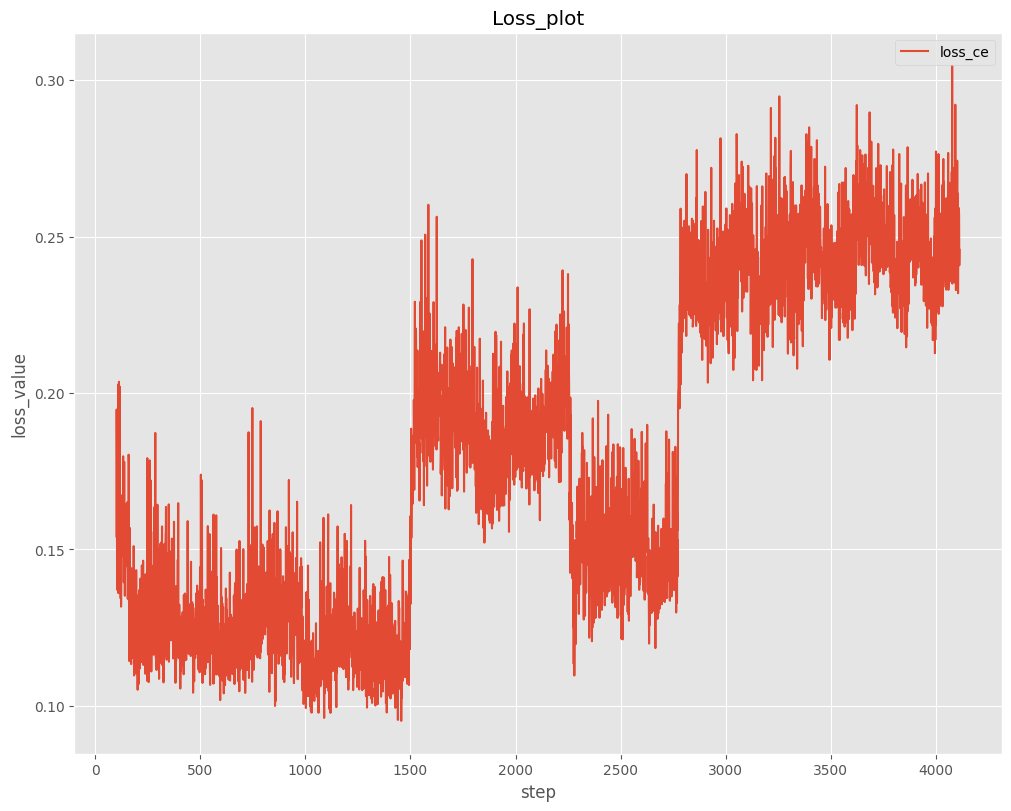

In [7]:

import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')
ax.plot(steps[100:], loss_ce[100:], label='loss_ce')  # Plot some data on the axes.
# Plot more data on the axes...
#ax.plot(steps[300:], loss_mask[300:], label='loss_mask')
#ax.plot(steps[300:], loss_dice[300:], label='loss_dice')  # ... and some more.
ax.set_xlabel('step')  # Add an x-label to the axes.
ax.set_ylabel('loss_value')  # Add a y-label to the axes.
ax.set_title("Loss_plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

plt.show()


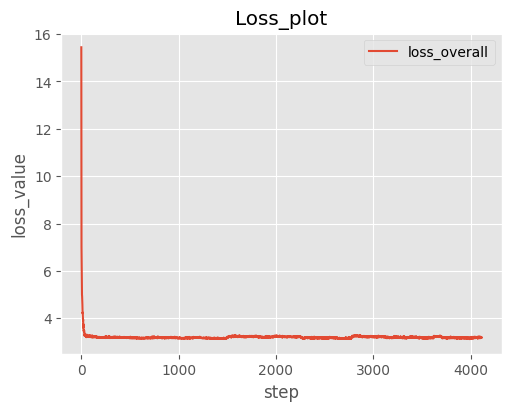

In [4]:
fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
# Plot some data on the axes.
ax.plot(steps, loss_overall, label='loss_overall')
# Plot more data on the axes...
# ax.plot(steps, loss_mask, label='loss_mask')
# ax.plot(steps, loss_dice, label='loss_dice')  # ... and some more.
ax.set_xlabel('step')  # Add an x-label to the axes.
ax.set_ylabel('loss_value')  # Add a y-label to the axes.
ax.set_title("Loss_plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

plt.show()


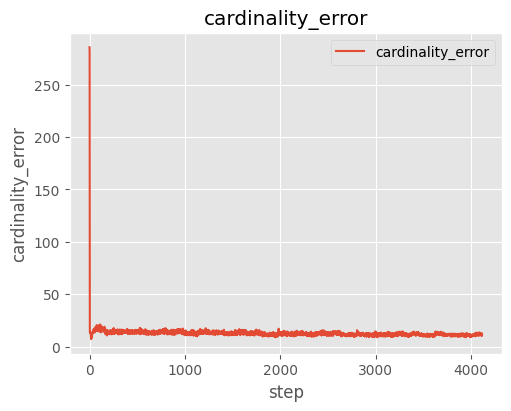

In [7]:
fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
# Plot some data on the axes.
ax.plot(steps, cardinality_error, label='cardinality_error')
# Plot more data on the axes...
# ax.plot(steps, loss_mask, label='loss_mask')
# ax.plot(steps, loss_dice, label='loss_dice')  # ... and some more.
ax.set_xlabel('step')  # Add an x-label to the axes.
ax.set_ylabel('cardinality_error')  # Add a y-label to the axes.
ax.set_title("cardinality_error")  # Add a title to the axes.
ax.legend()  # Add a legend.

plt.show()


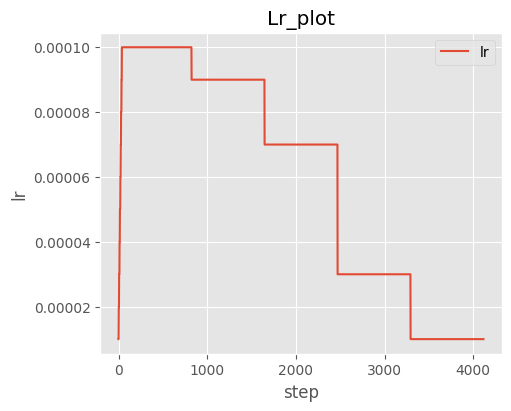

In [6]:
fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
# Plot some data on the axes.
ax.plot(steps, lr, label='lr')
# Plot more data on the axes...
# ax.plot(steps, loss_mask, label='loss_mask')
# ax.plot(steps, loss_dice, label='loss_dice')  # ... and some more.
ax.set_xlabel('step')  # Add an x-label to the axes.
ax.set_ylabel('lr')  # Add a y-label to the axes.
ax.set_title("Lr_plot")  # Add a title to the axes.
ax.legend()  # Add a legend.

plt.show()


# Viz labels

In [1]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

import numpy as np 
import matplotlib.pyplot as plt 
from mmcv import Config

ignore_index = 255

import torch 


INSTANCE_COLOURS = np.asarray([
    [0, 0, 0],
    [255, 179, 0],
    [128, 62, 117],
    [255, 104, 0],
    [166, 189, 215],
    [193, 0, 32],
    [206, 162, 98],
    [129, 112, 102],
    [0, 125, 52],
    [246, 118, 142],
    [0, 83, 138],
    [255, 122, 92],
    [83, 55, 122],
    [255, 142, 0],
    [179, 40, 81],
    [244, 200, 0],
    [127, 24, 13],
    [147, 170, 0],
    [89, 51, 21],
    [241, 58, 19],
    [35, 44, 22],
    [112, 224, 255],
    [70, 184, 160],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [0, 255, 235],
    [255, 0, 235],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 255, 204],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [255, 214, 0],
    [25, 194, 194],
    [92, 0, 255],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
])


def generate_instance_colours(instance_map):
    # Most distinct 22 colors (kelly colors from https://stackoverflow.com/questions/470690/how-to-automatically-generate
    # -n-distinct-colors)
    # plus some colours from AD40k

    return {instance_id: INSTANCE_COLOURS[global_instance_id % len(INSTANCE_COLOURS)] for
            instance_id, global_instance_id in instance_map.items()
            }

def plot_instance_map(instance_image, instance_map, instance_colours=None, bg_image=None):
    if isinstance(instance_image, torch.Tensor):
        instance_image = instance_image.cpu().numpy()
    assert isinstance(instance_image, np.ndarray)
    if instance_colours is None:
        instance_colours = generate_instance_colours(instance_map)
    if len(instance_image.shape) > 2:
        instance_image = instance_image.reshape(
            (instance_image.shape[-2], instance_image.shape[-1]))

    # white background + colorful objects
    if bg_image is None:
        plot_image = 255 * \
            np.ones(
                (instance_image.shape[0], instance_image.shape[1], 3), dtype=np.uint8)
    else:
        plot_image = bg_image

    for key, value in instance_colours.items():
        plot_image[instance_image == key] = value

    return plot_image



from projects.mmdet3d_plugin.datasets.utils.warper import FeatureWarper
import os


def import_modules_load_config(cfg_file="beverse_tiny.py", samples_per_gpu=1):
    cfg_path = r"/home/niklas/ETM_BEV/BEVerse/projects/configs"
    cfg_path = os.path.join(cfg_path, cfg_file)

    cfg = Config.fromfile(cfg_path)

    # if args.cfg_options is not None:
    #     cfg.merge_from_dict(args.cfg_options)
    # import modules from string list.
    if cfg.get("custom_imports", None):
        from mmcv.utils import import_modules_from_strings

        import_modules_from_strings(**cfg["custom_imports"])

    # import modules from plguin/xx, registry will be updated
    if hasattr(cfg, "plugin"):
        if cfg.plugin:
            import importlib

            if hasattr(cfg, "plugin_dir"):
                plugin_dir = cfg.plugin_dir
                _module_dir = os.path.dirname(plugin_dir)
                _module_dir = _module_dir.split("/")
                _module_path = _module_dir[0]

                for m in _module_dir[1:]:
                    _module_path = _module_path + "." + m
                print(_module_path)
                plg_lib = importlib.import_module(_module_path)
            else:
                # import dir is the dirpath for the config file
                _module_dir = cfg_path
                _module_dir = _module_dir.split("/")
                _module_path = _module_dir[0]
                for m in _module_dir[1:]:
                    _module_path = _module_path + "." + m
                print(_module_path)
                plg_lib = importlib.import_module(_module_path)

    samples_per_gpu = 1
    if isinstance(cfg.data.test, dict):
        cfg.data.test.test_mode = True
        samples_per_gpu = cfg.data.test.pop("samples_per_gpu", 1)
        if samples_per_gpu > 1:
            # Replace 'ImageToTensor' to 'DefaultFormatBundle'
            cfg.data.test.pipeline = replace_ImageToTensor(
                cfg.data.test.pipeline)
    elif isinstance(cfg.data.test, list):
        for ds_cfg in cfg.data.test:
            ds_cfg.test_mode = True
        samples_per_gpu = max(
            [ds_cfg.pop("samples_per_gpu", 1) for ds_cfg in cfg.data.test]
        )
        if samples_per_gpu > 1:
            for ds_cfg in cfg.data.test:
                ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

    return cfg


torch.backends.cudnn.benchmark = True

cfg = import_modules_load_config(
    cfg_file=r"beverse_tiny_org.py")






projects.mmdet3d_plugin


In [2]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False)


grid_conf = {
    "xbound": [-50.0, 50.0, 0.5],
    "ybound": [-50.0, 50.0, 0.5],
    "zbound": [-10.0, 10.0, 20.0],
    "dbound": [1.0, 60.0, 1.0],
}

warper = FeatureWarper(grid_conf=grid_conf)


In [3]:
iter_loader =iter(data_loader)


In [4]:
sample = next(iter_loader)


In [28]:
import math
import torch.nn.functional as F 


class pseud_class:
    def __init__(self) -> None:
        
        self.receptive_field = 4
        self.warper = FeatureWarper(grid_conf=grid_conf)
        self.ignore_index = 255
    def prepare_targets(self, batch,bev_size = (200,200), mask_stride=2,match_stride=2):
        segmentation_labels = batch["motion_segmentation"][0]
        gt_instance = batch["motion_instance"][0]
        future_egomotion = batch["future_egomotions"][0]
        batch_size = len(segmentation_labels)
        labels = {}

        bev_transform = batch.get("aug_transform", None)
        labels["img_is_valid"] = batch.get("img_is_valid", None)

        if bev_transform is not None:
            bev_transform = bev_transform.float()
        #warping so all segmentation labels are inside the current BEV frame FIERY reports better convergence / performance if you do this 
        segmentation_labels = (
            self.warper.cumulative_warp_features_reverse(
                segmentation_labels.float().unsqueeze(2),
                future_egomotion[:, (self.receptive_field - 1) :],
                mode="nearest",
                bev_transform=bev_transform,
            )
            .long()
            .contiguous()
        ).squeeze().to(torch.float32)
        #print(f"Seg labels shape: {segmentation_labels.shape =}")

        target_list = []
        for b in range(batch_size):
            gt_list = []
            #gt_instance[b] = gt_instance[b][gt_instance[b]!=self.ignore_index]
            ids = gt_instance[b].unique()

            ids = ids[ids != self.ignore_index]
            ids = ids[ids != 0]
            
            label_t_list = []
            for t in gt_instance[b]:
                t_labels = t.unique()
                t_labels = t_labels[t_labels != self.ignore_index]
                t_labels = t_labels[t_labels != 0]
                label_t_list.append(len(t_labels))

            for _id in ids:
                test_bool = torch.where(
                    gt_instance[b] == _id, 1., 0.)
                gt_list.append(test_bool)

            segmentation_labels = torch.stack(gt_list, dim=0)

            #segmentation_labels = torch.stack(gt_batch_instances_list,dim=0)
            o_h, o_w = segmentation_labels.shape[-2:]
            l_h, l_w = math.ceil(o_h/mask_stride), math.ceil(o_w/mask_stride)
            m_h, m_w = math.ceil(o_h/match_stride), math.ceil(o_w/match_stride)

            gt_masks_for_loss = F.interpolate(segmentation_labels, size=(
                l_h, l_w), mode="bilinear", align_corners=False)
            gt_masks_for_match = F.interpolate(segmentation_labels, size=(
                m_h, m_w), mode="bilinear", align_corners=False)

            # labels only continous for clip - this is much more of an tracking id as every class is a vehicle anyways # TODO make work with other types of superclasses other then vehicle
            #ids = gt_instance[b].unique()
            # print(
            #     f"Labels over {len(gt_instance[b])} for Batch {b+1}, no.labels {label_t_list} no.masks {gt_masks_for_match.shape}")
            target_list.append({"labels": ids, "masks": segmentation_labels,
                               "match_masks": segmentation_labels, "gt_motion_instance": gt_instance[b]})
        return target_list, future_egomotion[:, (self.receptive_field - 1):]


In [31]:
len(sample["semantic_map"][0])

2

In [6]:
segmentation_labels = sample["motion_segmentation"][0].to(torch.float32)

o_h, o_w = (200,200)
l_h, l_w = math.ceil(o_h/2), math.ceil(o_w/2)
m_h, m_w = math.ceil(o_h/2), math.ceil(o_w/2)
gt_masks_for_loss  = F.interpolate(segmentation_labels, size=(l_h, l_w), mode="bilinear", align_corners=False)
gt_masks_for_match = F.interpolate(segmentation_labels, size=(m_h, m_w), mode="bilinear", align_corners=False)

In [38]:
gt_masks_for_loss.shape

torch.Size([2, 4, 100, 100])

In [29]:
p = pseud_class()
target_list = p.prepare_targets(sample)

In [30]:
target_list=target_list[0][0]
target_list["labels"]


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [9]:
target_list["masks"].shape


torch.Size([14, 5, 100, 100])

In [31]:
motion_masks=target_list["masks"]


In [22]:
motion_masks=motion_masks.permute(1,0,2,3)

In [32]:
motion_masks.shape

torch.Size([14, 5, 200, 200])

In [33]:
motion_masks = motion_masks[:5]
motion_masks.shape

torch.Size([5, 5, 200, 200])

In [34]:
motion_masks=motion_masks.permute(1,0,2,3)

In [35]:
t1_motion_masks = motion_masks[0]
t1_motion_masks.shape

torch.Size([5, 200, 200])

In [37]:
t1_motion_masks.unique()

tensor([0., 1.])

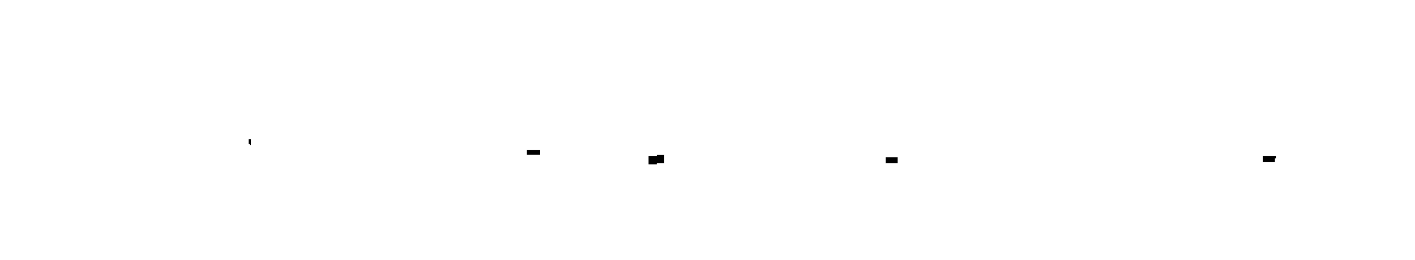

In [36]:
num_instances = t1_motion_masks.shape[0]
plt.figure(0, figsize=(18, 4))
for i in range(num_instances):
    plt.subplot(1, num_instances, i + 1)
    plt.imshow(t1_motion_masks[i])
    plt.axis('off')
    
plt.savefig(
                f'/home/niklas/ETM_BEV/VIS/viz/t1_motion_masks.png')


(-0.5, 199.5, 199.5, -0.5)

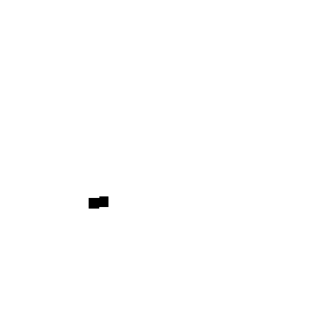

In [54]:

plt.figure(0, figsize=(18, 4))
plt.imshow(t1_motion_masks[2].numpy())
plt.axis('off')

In [24]:
gt_instance = target_list["gt_motion_instance"]
gt_instance.shape

torch.Size([5, 200, 200])

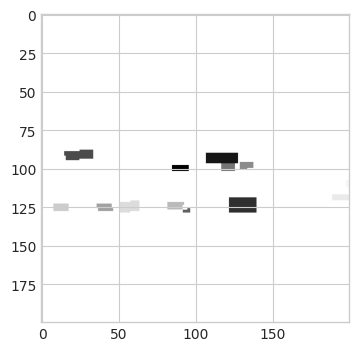

In [25]:
plt.figure(0, figsize=(18, 4))
plt.imshow(gt_instance[0])


In [38]:
test_bool = torch.where(
    gt_instance[0] == 0, 1., 0.)


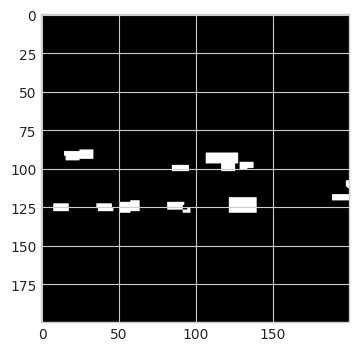

In [39]:
plt.figure(0, figsize=(18, 4))
plt.imshow(test_bool)
plt.axis('off')
plt.savefig(
                    f'/home/niklas/ETM_BEV/VIS/viz/test_bool{0}.png')



In [70]:
len(sample["motion_instance"][0][1].unique())

25

In [12]:

gt_instances = sample["motion_instance"][0]
#print(f"{gt_instance.shape = }")
future_egomotion = sample["future_egomotions"][0]
bev_transform = sample.get("aug_transform", None)
receptive_field = 4

gt_instance = (
    warper.cumulative_warp_features_reverse(
        gt_instances.float().unsqueeze(2),
        future_egomotion[:, (receptive_field - 1):],
        mode="nearest",
        bev_transform=bev_transform,
    )
    .long()
    .contiguous()[:, :, 0]
)

temporal_instances = gt_instance[0]
num_frame = temporal_instances.shape[0]
temporal_instances_real = gt_instance[0].clone()


instance_ids = np.unique(temporal_instances_real)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
print(instance_ids)
instance_map = dict(zip(instance_ids, instance_ids))

#num_frame = 1
temporal_instances[temporal_instances != 5] = 0

plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')
    plt.show()
plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances_real[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')

    # plt.savefig(
    #     f'{"/home/niklas/ETM_BEV/BEVerse/viz"}/temporal_instanceswarped_{i}.png')
    plt.show()


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


KeyboardInterrupt: 

In [125]:
sample = next(iter_loader)


[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 32 34 35]


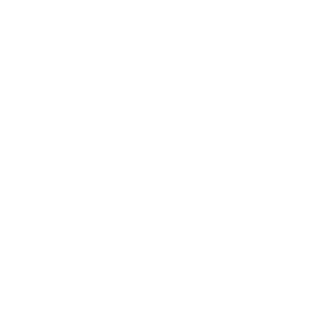

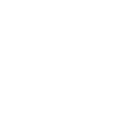

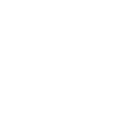

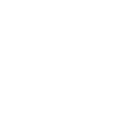

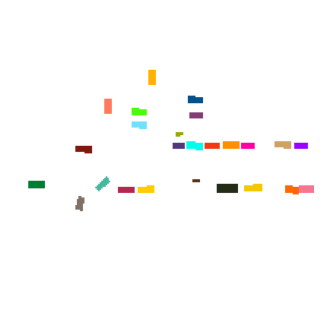

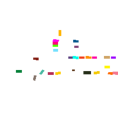

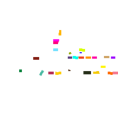

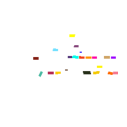

In [127]:
sample = next(iter_loader)
gt_instances = sample["motion_instance"][0]
#print(f"{gt_instance.shape = }")
future_egomotion = sample["future_egomotions"][0]
bev_transform = sample.get("aug_transform", None)
receptive_field = 4

gt_instance = (
    warper.cumulative_warp_features_reverse(
        gt_instances.float().unsqueeze(2),
        future_egomotion[:, (receptive_field - 1):],
        mode="nearest",
        bev_transform=bev_transform,
    )
    .long()
    .contiguous()[:, :, 0]
)

temporal_instances = gt_instance[0]
num_frame = temporal_instances.shape[0]
temporal_instances_real = gt_instance[0].clone()


instance_ids = np.unique(temporal_instances_real)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
print(instance_ids)
instance_map = dict(zip(instance_ids, instance_ids))

#num_frame = 1
temporal_instances[temporal_instances != 5] = 0

plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')
    plt.show()
plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances_real[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')

    # plt.savefig(
    #     f'{"/home/niklas/ETM_BEV/BEVerse/viz"}/temporal_instanceswarped_{i}.png')
    plt.show()


In [85]:
sample.keys()

dict_keys(['img_metas', 'img_inputs', 'semantic_indices', 'semantic_map', 'future_egomotions', 'gt_bboxes_3d', 'gt_labels_3d', 'motion_segmentation', 'motion_instance', 'instance_centerness', 'instance_offset', 'instance_flow', 'has_invalid_frame', 'img_is_valid'])

In [9]:
temporal_instances = sample['motion_instance'][0]
num_frame = temporal_instances.shape[0]


1


In [19]:
temporal_instances.shape

torch.Size([1, 4, 200, 200])

In [10]:
instance_ids = np.unique(temporal_instances)[1:]


In [11]:
instance_ids


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [13]:
instance_ids = instance_ids[instance_ids != ignore_index]
instance_ids


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [15]:
instance_map = dict(zip(instance_ids, instance_ids))
instance_map


{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21}

In [20]:
temporal_instances[0].shape

torch.Size([4, 200, 200])

In [23]:
sample.keys()


dict_keys(['img_metas', 'img_inputs', 'semantic_indices', 'semantic_map', 'future_egomotions', 'gt_bboxes_3d', 'gt_labels_3d', 'motion_segmentation', 'motion_instance', 'instance_centerness', 'instance_offset', 'instance_flow', 'has_invalid_frame', 'img_is_valid'])

In [77]:
sample["instance_flow"][0].shape


torch.Size([1, 4, 2, 200, 200])

In [79]:
out = sample["instance_flow"][0].reshape(
    (4, 2, sample["instance_flow"][0].shape[-2], sample["instance_flow"][0].shape[-1])).clone()


torch.Size([4, 2, 200, 200])

In [81]:
np.unique(out[0])[1:]


array([  0.,   1.,   2.,   4., 255.], dtype=float32)

In [68]:
int_out = out.to(torch.int16).numpy()

In [59]:
out.shape

torch.Size([3, 200, 400])

In [61]:
int_out.shape

(3, 200, 400)

In [69]:
c = 1
for i in range(len(int_out)):
    int_out[i] = int_out[i]*c
    c +=1
np.unique(int_out)

array([0, 1, 2, 3, 4], dtype=int16)

In [53]:
int_out.shape

(2,)

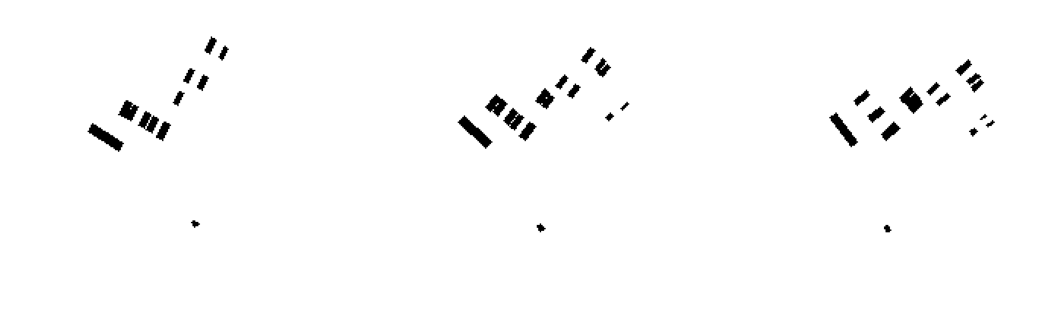

In [70]:
plt.figure(0, figsize=(18, 4))
for i in range(3):
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(int_out[i])
    plt.axis('off')


In [22]:
temporal_instances = sample['motion_instance'][0][0]
num_frame = temporal_instances.shape[0]

instance_ids = np.unique(temporal_instances)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
instance_map = dict(zip(instance_ids, instance_ids))

plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')

plt.savefig(
    '{}/temporal_instances.png'.format(r'/home/niklas/ETM_BEV/BEVerse/viz'))
plt.close()


In [93]:
type(bev_transform)


NoneType

In [89]:
gt_instances.shape


torch.Size([1, 4, 200, 200])

In [88]:
gt_instances.float().unsqueeze(2).shape


torch.Size([1, 4, 1, 200, 200])

In [92]:
future_egomotion[0][:, (receptive_field - 1):].shape


torch.Size([1, 4, 6])

In [111]:
temporal_instances = sample['motion_instance'][0][0]
num_frame = temporal_instances.shape[0]

instance_ids = np.unique(temporal_instances)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
instance_map = dict(zip(instance_ids, instance_ids))


for i in range(num_frame):
    plt.figure(0, figsize=(18, 4))
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    #plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')
    plt.savefig(
        f'/home/niklas/ETM_BEV/BEVerse/viz/temporal_instances_not_warped_{i}.png')
    plt.close()


In [101]:
temporal_instances.shape

torch.Size([1, 4, 200, 200])

In [102]:
gt_instance.shape

torch.Size([1, 4, 200, 200])

1

# VIS Model

In [ ]:
from mmcv.runner import (HOOKS, build_optimizer,
                         build_runner)
from mmdet3d.utils import collect_env
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmcv.parallel import MMDataParallel
from mmdet3d.datasets import build_dataset
from mmdet3d.models import build_model
from mmcv.runner import wrap_fp16_model
from mmcv import Config
from timeit import default_timer as timer
import torch.utils.benchmark as benchmark
import torch.nn as nn
import torch
from mmdet import __version__ as mmdet_version
from mmdet3d import __version__ as mmdet3d_version
from mmseg import __version__ as mmseg_version
import os
from custome_logger import setup_custom_logger
logger = setup_custom_logger()
logger.debug("test")
torch.backends.cudnn.benchmark = True


def update_cfg(
    cfg,
    n_future=4,
    receptive_field=3,
    resize_lim=(0.38, 0.55),
    final_dim=(256, 704),
    grid_conf={
        "xbound": [-51.2, 51.2, 0.8],
        "ybound": [-51.2, 51.2, 0.8],
        "zbound": [-10.0, 10.0, 20.0],
        "dbound": [1.0, 60.0, 1.0],
    },
    det_grid_conf={
        "xbound": [-51.2, 51.2, 0.8],
        "ybound": [-51.2, 51.2, 0.8],
        "zbound": [-10.0, 10.0, 20.0],
        "dbound": [1.0, 60.0, 1.0],
    },
    map_grid_conf={
        "xbound": [-30.0, 30.0, 0.15],
        "ybound": [-15.0, 15.0, 0.15],
        "zbound": [-10.0, 10.0, 20.0],
        "dbound": [1.0, 60.0, 1.0],
    },
    motion_grid_conf={
        "xbound": [-50.0, 50.0, 0.5],
        "ybound": [-50.0, 50.0, 0.5],
        "zbound": [-10.0, 10.0, 20.0],
        "dbound": [1.0, 60.0, 1.0],
    },
    t_input_shape=(128, 128),
    point_cloud_range=[-51.2, -51.2, -5.0, 51.2, 51.2, 3.0],
):

    cfg["det_grid_conf"] = det_grid_conf
    cfg["map_grid_conf"] = map_grid_conf
    cfg["motion_grid_conf"] = motion_grid_conf
    cfg["grid_conf"] = det_grid_conf

    cfg["model"]["temporal_model"]["input_shape"] = t_input_shape

    cfg["data"]["val"]["pipeline"][0]["data_aug_conf"]["resize_lim"] = resize_lim
    cfg["data"]["train"]["dataset"]["pipeline"][0]["data_aug_conf"][
        "resize_lim"
    ] = resize_lim
    cfg["data"]["val"]["pipeline"][0]["data_aug_conf"]["final_dim"] = final_dim
    cfg["data"]["train"]["dataset"]["pipeline"][0]["data_aug_conf"][
        "final_dim"
    ] = final_dim

    cfg["data"]["test"]["pipeline"][0]["data_aug_conf"]["resize_lim"] = resize_lim
    cfg["data"]["test"]["pipeline"][0]["data_aug_conf"]["final_dim"] = final_dim

    cfg["model"]["pts_bbox_head"]["cfg_motion"][
        "grid_conf"
    ] = motion_grid_conf  # motion_grid
    cfg["model"]["temporal_model"]["grid_conf"] = grid_conf
    cfg["model"]["transformer"]["grid_conf"] = grid_conf
    cfg["model"]["pts_bbox_head"]["grid_conf"] = grid_conf
    cfg["data"]["train"]["dataset"]["grid_conf"] = motion_grid_conf
    cfg["data"]["val"]["pipeline"][3]["grid_conf"] = motion_grid_conf
    cfg["data"]["test"]["pipeline"][3]["grid_conf"] = motion_grid_conf
    cfg["data"]["val"]["grid_conf"] = grid_conf
    cfg["data"]["test"]["grid_conf"] = grid_conf

    cfg["model"]["pts_bbox_head"]["det_grid_conf"] = det_grid_conf

    cfg["model"]["pts_bbox_head"]["map_grid_conf"] = map_grid_conf
    cfg["data"]["train"]["dataset"]["map_grid_conf"] = map_grid_conf
    cfg["data"]["test"]["pipeline"][2]["map_grid_conf"] = map_grid_conf
    cfg["data"]["val"]["pipeline"][2]["map_grid_conf"] = map_grid_conf
    cfg["data"]["test"]["map_grid_conf"] = map_grid_conf
    cfg["data"]["val"]["map_grid_conf"] = map_grid_conf

    cfg["model"]["pts_bbox_head"]["motion_grid_conf"] = motion_grid_conf

    cfg["data"]["test"]["pipeline"][5]["point_cloud_range"] = point_cloud_range
    cfg["data"]["train"]["pipeline"][5][
        "point_cloud_range"
    ] = point_cloud_range  # point_cloud_range=None
    cfg["data"]["train"]["pipeline"][6][
        "point_cloud_range"
    ] = point_cloud_range  # 'point_cloud_range =None
    cfg["data"]["val"]["pipeline"][5]["point_cloud_range"] = point_cloud_range

    cfg["model"]["pts_bbox_head"]["cfg_motion"]["receptive_field"] = receptive_field
    cfg["data"]["train"]["dataset"]["receptive_field"] = receptive_field
    cfg["model"]["temporal_model"]["receptive_field"] = receptive_field
    cfg["data"]["test"]["receptive_field"] = receptive_field
    cfg["data"]["val"]["receptive_field"] = receptive_field

    cfg["data"]["val"]["future_frames"] = n_future
    cfg["model"]["pts_bbox_head"]["cfg_motion"]["n_future"] = n_future
    cfg["data"]["test"]["future_frames"] = n_future
    cfg["data"]["train"]["dataset"]["future_frames"] = n_future

    cfg["data"]["train"]["dataset"]["pipeline"][4]["map_grid_conf"] = map_grid_conf
    cfg["data"]["train"]["dataset"]["pipeline"][5]["grid_conf"] = motion_grid_conf
    cfg["data"]["train"]["dataset"]["pipeline"][7]["point_cloud_range"] = point_cloud_range

    return cfg


def import_modules_load_config(cfg_file="beverse_tiny.py", samples_per_gpu=1):
    cfg_path = r"/home/niklas/ETM_BEV/BEVerse/projects/configs"
    cfg_path = os.path.join(cfg_path, cfg_file)

    cfg = Config.fromfile(cfg_path)

    # if args.cfg_options is not None:
    #     cfg.merge_from_dict(args.cfg_options)
    # import modules from string list.
    if cfg.get("custom_imports", None):
        from mmcv.utils import import_modules_from_strings

        import_modules_from_strings(**cfg["custom_imports"])

    # import modules from plguin/xx, registry will be updated
    if hasattr(cfg, "plugin"):
        if cfg.plugin:
            import importlib

            if hasattr(cfg, "plugin_dir"):
                plugin_dir = cfg.plugin_dir
                _module_dir = os.path.dirname(plugin_dir)
                _module_dir = _module_dir.split("/")
                _module_path = _module_dir[0]

                for m in _module_dir[1:]:
                    _module_path = _module_path + "." + m
                print(_module_path)
                plg_lib = importlib.import_module(_module_path)
            else:
                # import dir is the dirpath for the config file
                _module_dir = cfg_path
                _module_dir = _module_dir.split("/")
                _module_path = _module_dir[0]
                for m in _module_dir[1:]:
                    _module_path = _module_path + "." + m
                print(_module_path)
                plg_lib = importlib.import_module(_module_path)

    samples_per_gpu = 1
    if isinstance(cfg.data.test, dict):
        cfg.data.test.test_mode = True
        samples_per_gpu = cfg.data.test.pop("samples_per_gpu", 1)
        if samples_per_gpu > 1:
            # Replace 'ImageToTensor' to 'DefaultFormatBundle'
            cfg.data.test.pipeline = replace_ImageToTensor(
                cfg.data.test.pipeline)
    elif isinstance(cfg.data.test, list):
        for ds_cfg in cfg.data.test:
            ds_cfg.test_mode = True
        samples_per_gpu = max(
            [ds_cfg.pop("samples_per_gpu", 1) for ds_cfg in cfg.data.test]
        )
        if samples_per_gpu > 1:
            for ds_cfg in cfg.data.test:
                ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

    return cfg


@torch.no_grad()
def measure_time_host(
    model: nn.Module,
    input_tensor: torch.Tensor,
    num_repeats: int = 100,
    num_warmups: int = 10,
    synchronize: bool = True,
    continuous_measure: bool = True,
) -> float:

    for _ in range(num_warmups):
        _ = model.forward(input_tensor)
    torch.cuda.synchronize()

    elapsed_time_ms = 0

    if continuous_measure:
        start = timer()
        for _ in range(num_repeats):
            _ = model.forward(input_tensor)
        if synchronize:
            torch.cuda.synchronize()
        end = timer()
        elapsed_time_ms = (end - start) * 1000

    else:
        for _ in range(num_repeats):
            start = timer()
            _ = model.forward(input_tensor)
            if synchronize:
                torch.cuda.synchronize()
            end = timer()
            elapsed_time_ms += (end - start) * 1000

    return elapsed_time_ms / num_repeats


@torch.no_grad()
def measure_time_device(
    model: nn.Module,
    input_tensor: torch.Tensor,
    num_repeats: int = 100,
    num_warmups: int = 10,
    synchronize: bool = True,
    continuous_measure: bool = True,
) -> float:

    for _ in range(num_warmups):
        _ = model.forward(input_tensor)
    torch.cuda.synchronize()

    elapsed_time_ms = 0

    if continuous_measure:
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        for _ in range(num_repeats):
            _ = model.forward(input_tensor)
        end_event.record()
        if synchronize:
            # This has to be synchronized to compute the elapsed time.
            # Otherwise, there will be runtime error.
            torch.cuda.synchronize()
        elapsed_time_ms = start_event.elapsed_time(end_event)

    else:
        for _ in range(num_repeats):
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            _ = model.forward(input_tensor)
            end_event.record()
            if synchronize:
                # This has to be synchronized to compute the elapsed time.
                # Otherwise, there will be runtime error.
                torch.cuda.synchronize()
            elapsed_time_ms += start_event.elapsed_time(end_event)

    return elapsed_time_ms / num_repeats


@torch.no_grad()
def run_inference(model: nn.Module, input_tensor: torch.Tensor) -> torch.Tensor:
    # from model.forward because BEVerse differentiates between different input types - img lidar etc
    return model.forward_dummy()


def calculate_birds_eye_view_parameters(x_bounds, y_bounds, z_bounds):
    """
    Parameters
    ----------
        x_bounds: Forward direction in the ego-car.
        y_bounds: Sides
        z_bounds: Height

    Returns
    -------
        bev_resolution: Bird's-eye view bev_resolution
        bev_start_position Bird's-eye view first element
        bev_dimension Bird's-eye view tensor spatial dimension
    """
    bev_resolution = torch.tensor(
        [row[2] for row in [x_bounds, y_bounds, z_bounds]])
    bev_start_position = torch.tensor(
        [row[0] + row[2] / 2.0 for row in [x_bounds, y_bounds, z_bounds]]
    )
    bev_dimension = torch.tensor(
        [(row[1] - row[0]) / row[2] for row in [x_bounds, y_bounds, z_bounds]],
        dtype=torch.long,
    )

    return bev_resolution, bev_start_position, bev_dimension


In [ ]:
cfg = import_modules_load_config(cfg_file="motion_detr_tiny.py")
dataset = build_dataset(cfg.data.test)  # build_dataset(cfg.data.train)
data_loaders = [build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False)]

sample = next(iter(data_loaders[0]))

model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'),
                    test_cfg=cfg.get('test_cfg'))

cfg.checkpoint_config.meta = dict(
    mmdet_version=mmdet_version,
    mmseg_version=mmseg_version,
    mmdet3d_version=mmdet3d_version,
    config=cfg.pretty_text,
    CLASSES=dataset.CLASSES,
    PALETTE=dataset.PALETTE  # for segmentors
    if hasattr(dataset, 'PALETTE') else None)

weights_tiny = torch.load(
    "/home/niklas/ETM_BEV/BEVerse/logs_cluster/epoch_5.pth")#['state_dict']

model.load_state_dict(weights_tiny)
model.cuda()
model = MMDataParallel(model, device_ids=[0])

cfg.work_dir = "./"
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info
meta['config'] = cfg.pretty_text
meta['seed'] = 1337
meta['exp_name'] = "testname"

optimizer = build_optimizer(model, cfg.optimizer)

cfg.runner = {
    'type': 'EpochBasedRunner',
    'max_epochs': 1
}

runner = build_runner(
    cfg.runner,
    default_args=dict(
        model=model,
        optimizer=optimizer,
        work_dir=cfg.work_dir,
        logger=logger,
        meta=meta))

with torch.no_grad():
    runner.run(data_loaders, cfg.workflow)




